# E3 Analysis

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the original datasets
#df_dynamic = pd.read_excel("Dynamic Crowds.xlsx", sheet_name="Dynamic Crowds")
#df_eyetracking = pd.read_csv("e3 eyetracking sample.csv")
df_fixations = pd.read_csv("list_of_fixations.csv")
df_variables = pd.read_csv("list_of_variables.csv")

df_variables["file_name"] = df_variables["subID"]
df_variables = df_variables.drop(columns=["subID"])

df_variables.head()
df_fixations.head()

df_fixations["file_name"] = df_fixations["subID"]
df_fixations = df_fixations.drop(columns=["subID"])

# Create a pivot table with trial and file_name as index
df_variables_wide = df_variables.pivot_table(index=['trial', 'file_name'], 
                                             columns='variable', 
                                             values='value', 
                                             aggfunc='first')

# Ensure trial is treated as a string to avoid dtype mismatches
df_fixations['trial'] = df_fixations['trial'].astype(str)
df_variables_wide.index = df_variables_wide.index.set_levels(df_variables_wide.index.levels[0].astype(str), level=0)

# Create a mapping dictionary from df_variables_wide
# Create a list of columns to map
columns_to_map = ["stimOrg", "responseKey", "stim1_pos", "stim2_pos", "stim3_pos", "stim4_pos"]

# Iterate through the columns and apply mapping dynamically
for col in columns_to_map:
    mapping = df_variables_wide[col].to_dict()
    df_fixations[col] = df_fixations.set_index(['trial', 'file_name']).index.map(mapping)

# Reset index if needed (optional)
df_fixations.reset_index(inplace=True)

# Display first few rows of the updated df_fixations
# print(df_fixations.head())


stim1 always target if all the same
0-50 - 100 - 150
fearful happy angry

# DF

In [7]:
import pandas as pd
import numpy as np

# Define the mapping of coordinates to box numbers (left to right)
coord_to_box = {
    str([-315.47, 130.67]): 1,  # leftmost
    str([-130.67, 315.47]): 2,
    str([130.67, 315.47]): 3,
    str([315.47, 130.67]): 4   # rightmost
}

data = []

# Iterate through each combination of subject ID and stimulus organization
for file_name in df_fixations['file_name'].unique():
    for selected_stimOrg in df_fixations[df_fixations['file_name'] == file_name]['stimOrg'].unique():
        # Get data for this specific subject and stimulus organization
        tmpdata = df_fixations[
            (df_fixations['file_name'] == file_name) & 
            (df_fixations['stimOrg'] == selected_stimOrg)
        ]
        
        if len(tmpdata) == 0:
            continue
            
        # Get the target position and map it to box number
        stim1_pos = tmpdata['stim1_pos'].iloc[0]
        target_box = coord_to_box[str(stim1_pos)]

        tmpdata_gaze = tmpdata[['gavx', 'gavy']].dropna()
        
        # Count fixations for each box
        box_counts = []
        for pos in screen_positions:
            box_x, box_y = pos
            count = count_fixations_in_box(tmpdata_gaze, box_x, box_y)
            box_counts.append(count)
        
        # Calculate percentages and create data row
        total_fixations = sum(box_counts)
        if total_fixations > 0:
            percentages = [count/total_fixations * 100 for count in box_counts]
        else:
            percentages = [0, 0, 0, 0]
            
        # Get target and non-target percentages
        target_percentage = percentages[target_box - 1]
        non_target_boxes = [i for i in range(4) if i != target_box - 1]
        non_target_percentage = sum([percentages[i] for i in non_target_boxes])
        non_target_percentage1 = np.mean([percentages[i] for i in non_target_boxes])

        data.append({
            'file_name': file_name,
            'stimOrg': selected_stimOrg,
            'target_box': target_box,
            'target_percentage': target_percentage,
            'non_target_percentage': non_target_percentage,
            'non_target_percentage1': non_target_percentage1,
            'box1_fixations': box_counts[0],
            'box2_fixations': box_counts[1],
            'box3_fixations': box_counts[2],
            'box4_fixations': box_counts[3],
            'total_fixations': total_fixations,
            'box1_percentage': percentages[0],
            'box2_percentage': percentages[1],
            'box3_percentage': percentages[2],
            'box4_percentage': percentages[3]
        })

# Create and sort the dataframe
df_fixation_counts = pd.DataFrame(data)
df_fixation_counts = df_fixation_counts.sort_values(['file_name', 'stimOrg'])

# Round percentage columns to 2 decimal places
percentage_columns = ['box1_percentage', 'box2_percentage', 'box3_percentage', 
                     'box4_percentage', 'target_percentage', 'non_target_percentage']
df_fixation_counts[percentage_columns] = df_fixation_counts[percentage_columns].round(2)

print("\nFixation Analysis with Target and Non-target Percentages:")
df_fixation_counts

NameError: name 'count_fixations_in_box' is not defined

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 1. Overall summary statistics
summary_stats = df_fixation_counts.groupby('stimOrg').agg({
    'target_percentage': ['mean', 'std', 'count'],
    'non_target_percentage': ['mean', 'std']
}).round(2)

print("Summary Statistics by Stimulus Organization:")
print(summary_stats)

# Create visualizations
# plt.style.use('seaborn')
fig = plt.figure(figsize=(20, 15))

# 1. Target vs Non-target Box Comparison
plt.subplot(2, 2, 1)
data_melted = pd.melt(df_fixation_counts, 
                      value_vars=['target_percentage', 'non_target_percentage'],
                      id_vars=['stimOrg'])
sns.boxplot(x='stimOrg', y='value', hue='variable', data=data_melted)
plt.title('Target vs Non-target Fixation Percentages by Stimulus Organization')
plt.xticks(rotation=45)
plt.ylabel('Percentage of Fixations')

# 2. Distribution of Target Fixations
plt.subplot(2, 2, 2)
sns.violinplot(x='stimOrg', y='target_percentage', data=df_fixation_counts)
plt.title('Distribution of Target Fixation Percentages')
plt.xticks(rotation=45)
plt.ylabel('Target Fixation Percentage')

# 3. Individual Box Percentages
plt.subplot(2, 2, 3)
box_data = pd.melt(df_fixation_counts, 
                   value_vars=['box1_percentage', 'box2_percentage', 
                             'box3_percentage', 'box4_percentage'],
                   id_vars=['stimOrg'])
sns.boxplot(x='stimOrg', y='value', hue='variable', data=box_data)
plt.title('Fixation Percentages by Box Position')
plt.xticks(rotation=45)
plt.ylabel('Percentage of Fixations')

# 4. Target Box Location Distribution
plt.subplot(2, 2, 4)
sns.countplot(data=df_fixation_counts, x='target_box', hue='stimOrg')
plt.title('Distribution of Target Box Locations by Stimulus Organization')
plt.xlabel('Target Box Position')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Statistical Analysis
print("\nStatistical Analysis:")

# 1. Paired t-test between target and non-target percentages for each stimOrg
print("\nPaired t-tests between target and non-target percentages:")
for stim in df_fixation_counts['stimOrg'].unique():
    stim_data = df_fixation_counts[df_fixation_counts['stimOrg'] == stim]
    t_stat, p_val = stats.ttest_rel(stim_data['target_percentage'], 
                                   stim_data['non_target_percentage'])
    print(f"\nStimOrg {stim}:")
    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_val:.3f}")

# 2. Create a summary table of mean fixation percentages by box position
box_summary = df_fixation_counts.groupby('stimOrg')[
    ['box1_percentage', 'box2_percentage', 'box3_percentage', 'box4_percentage']
].mean().round(2)

print("\nMean Fixation Percentages by Box Position:")
print(box_summary)

# 3. Calculate effect sizes (Cohen's d) for target vs non-target
print("\nEffect Sizes (Cohen's d) for Target vs Non-target:")
for stim in df_fixation_counts['stimOrg'].unique():
    stim_data = df_fixation_counts[df_fixation_counts['stimOrg'] == stim]
    d = (stim_data['target_percentage'].mean() - stim_data['non_target_percentage'].mean()) / \
        np.sqrt((stim_data['target_percentage'].std()**2 + stim_data['non_target_percentage'].std()**2) / 2)
    print(f"{stim}: {d:.3f}")

# Heatmaps for each stimulus with fixations count for each box (face)

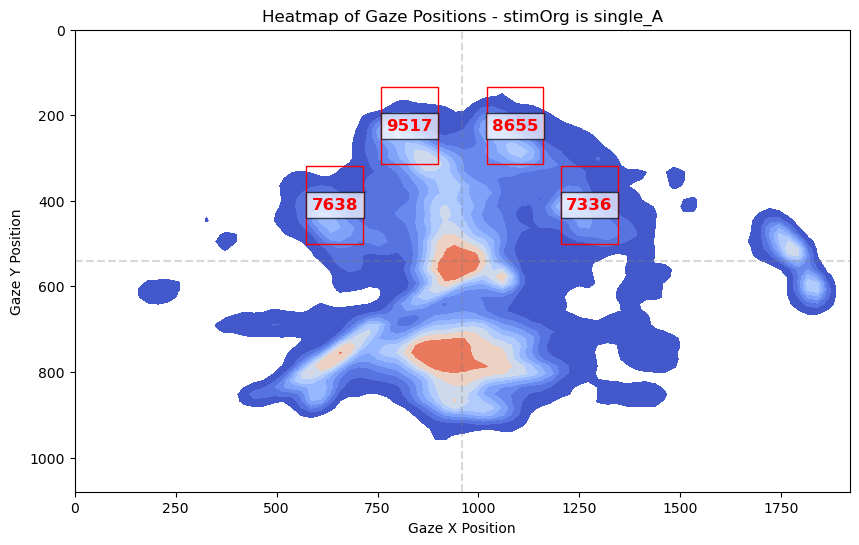

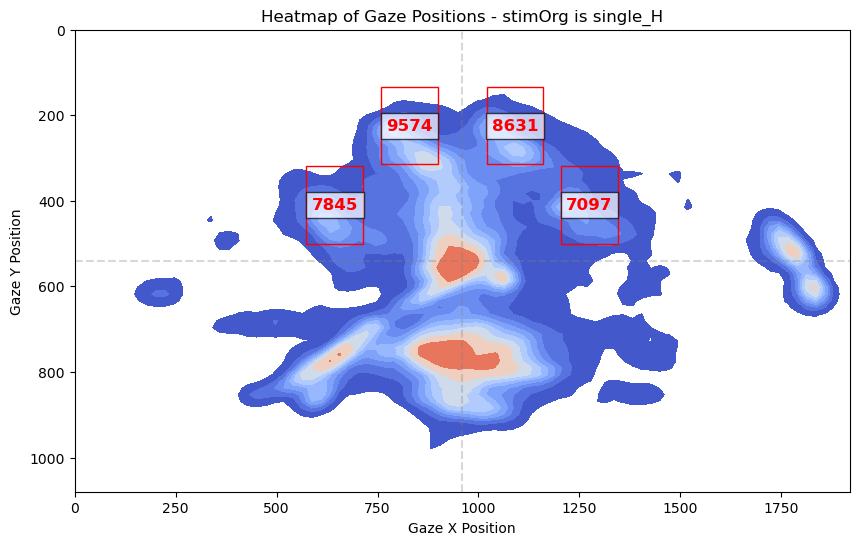

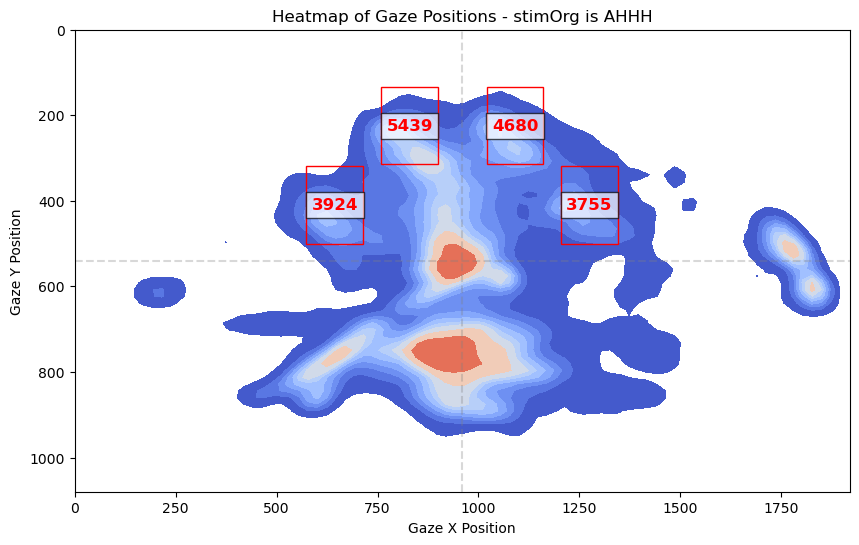

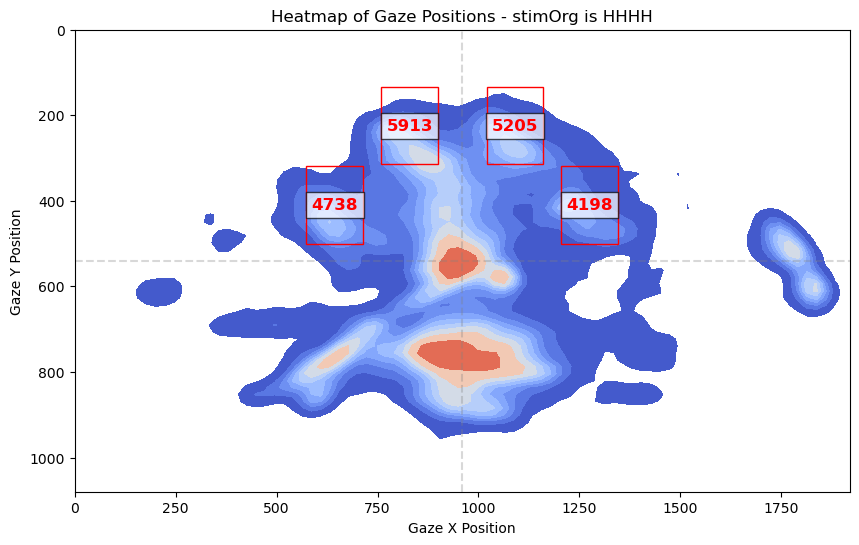

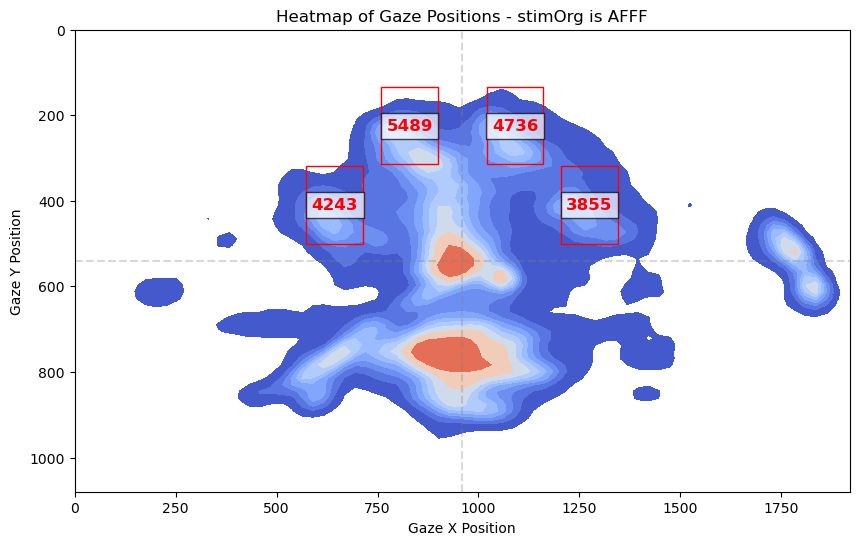

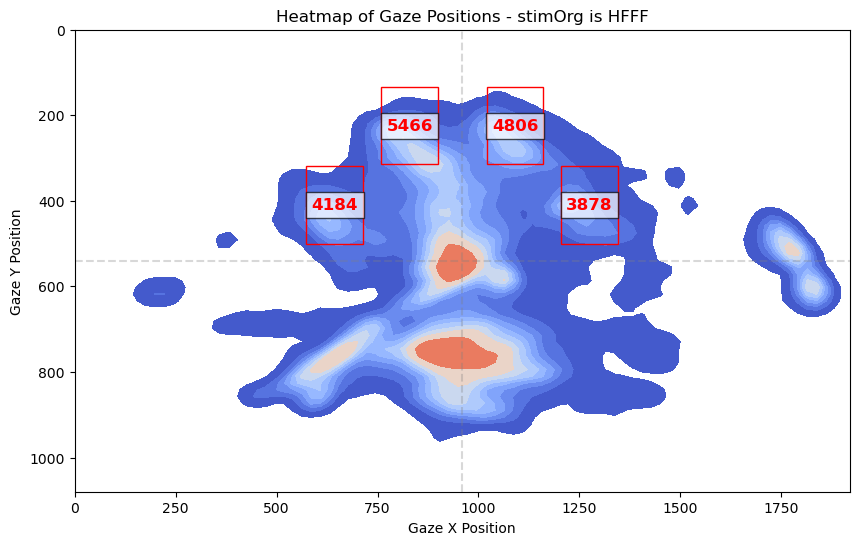

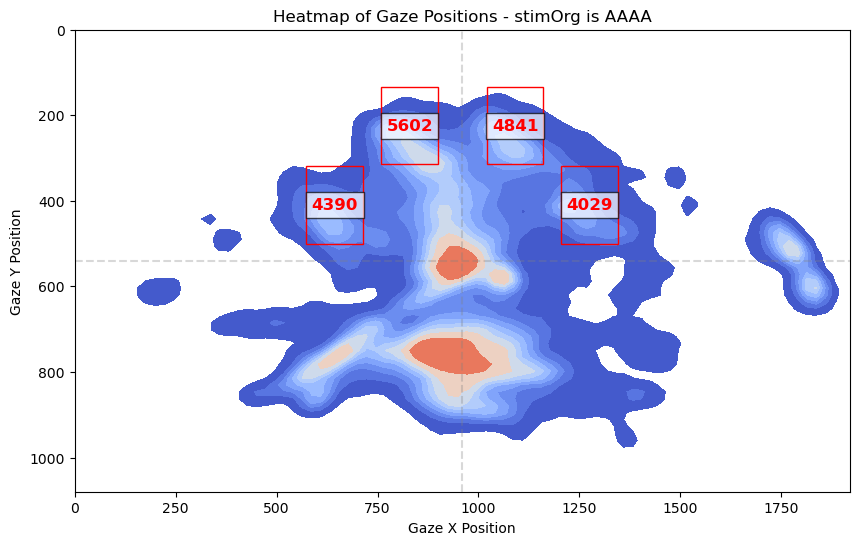

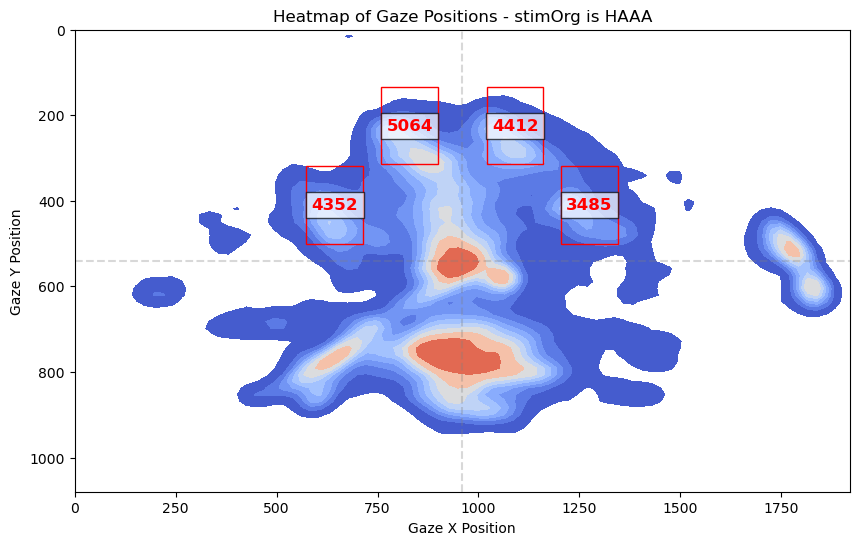

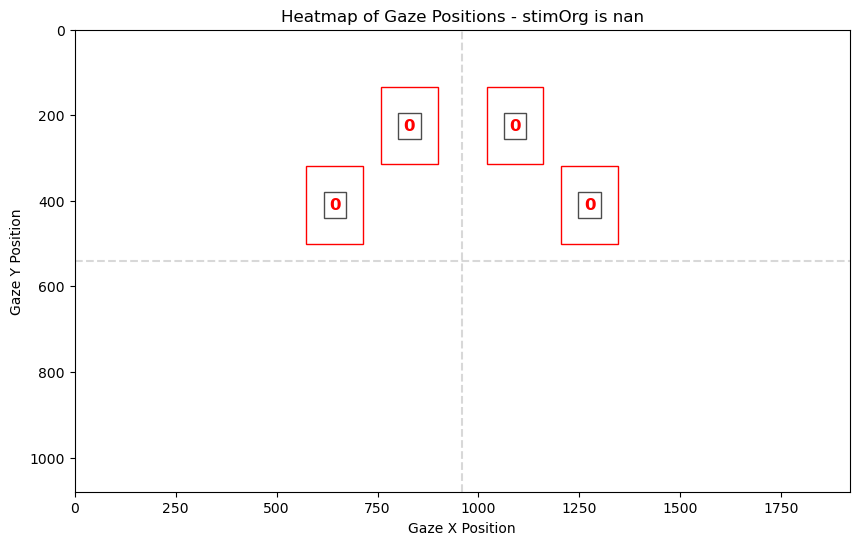

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def centered_to_screen(x, y, screen_width=1920, screen_height=1080):
    center_x = screen_width / 2
    center_y = screen_height / 2
    return x + center_x - 70.5, center_y - y - 90.5  # Adjust offsets if necessary

def count_fixations_in_box(fixations, box_x, box_y, box_width=141, box_height=181):
    """Count the number of fixations within a given rectangle."""
    x_min, x_max = box_x, box_x + box_width
    y_min, y_max = box_y, box_y + box_height
    return ((fixations['gavx'] >= x_min) & 
            (fixations['gavx'] <= x_max) & 
            (fixations['gavy'] >= y_min) & 
            (fixations['gavy'] <= y_max)).sum()

# Extract relevant columns for heatmap analysis
gaze_fixations = df_fixations[['gavx', 'gavy']].dropna()

# Face positions in centered coordinates
face_positions = [[130.67, 315.47], [-315.47, 130.67], [315.47, 130.67], [-130.67, 315.47]]

for selected_stimOrg in df_fixations.stimOrg.unique():
    tmpdata = df_fixations[df_fixations.stimOrg == selected_stimOrg]
    tmpdata = tmpdata[['gavx', 'gavy']].dropna()
    
    plt.figure(figsize=(10, 6))
    
    # Plot gaze data in screen coordinates
    sns.kdeplot(x=tmpdata['gavx'], y=tmpdata['gavy'], cmap="coolwarm", fill=True, bw_adjust=0.5)
    
    # Convert and plot face positions from centered to screen coordinates
    screen_positions = [centered_to_screen(x, y) for x, y in face_positions]
    
    for pos in screen_positions:
        box_x, box_y = pos
        num_fixations = count_fixations_in_box(tmpdata, box_x, box_y)
        
        # Draw face bounding box
        rect = plt.Rectangle((box_x, box_y), 141, 181, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Display fixation count inside the box
        plt.text(box_x + 70.5, box_y + 90.5, str(num_fixations), fontsize=12, color='red', 
                 ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))

    plt.title(f"Heatmap of Gaze Positions - stimOrg is {selected_stimOrg}")
    plt.xlabel("Gaze X Position")
    plt.ylabel("Gaze Y Position")
    plt.gca().invert_yaxis()  # Invert y-axis to match screen coordinates
    plt.ylim(1080, 0)
    plt.xlim(0, 1920)
    
    # Optional: Add grid to show center point
    plt.axhline(y=540, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=960, color='gray', linestyle='--', alpha=0.3)
    
    plt.show()
    # break  # Show for only one stimulus organization

plt.tight_layout()
plt.show()


# Heatmaps for each stimulus but only fixations count that are the last before the next fixation drops below y=650.

Trying to find fixations before the user goes to click answer

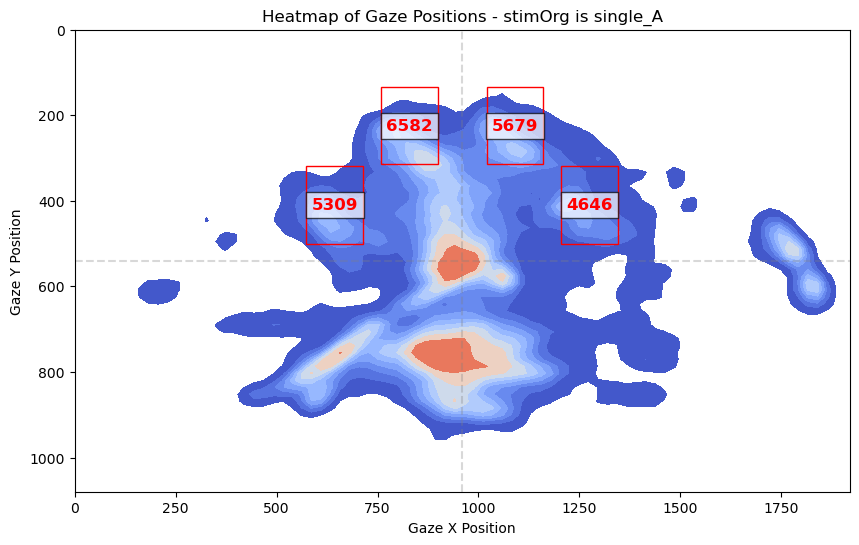

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def centered_to_screen(x, y, screen_width=1920, screen_height=1080):
    """Convert centered coordinates to screen coordinates."""
    center_x = screen_width / 2
    center_y = screen_height / 2
    return x + center_x - 70.5, center_y - y - 90.5  # Adjust offsets if necessary

def count_filtered_fixations(fixations, box_x, box_y, box_width=141, box_height=181):
    """Count fixations inside the box that are the last before the next fixation drops below y=650."""
    x_min, x_max = box_x, box_x + box_width
    y_min, y_max = box_y, box_y + box_height

    # Sort fixations by trial and timestamp
    fixations = fixations.sort_values(by=['trial', 'sttime'])

    # Find last fixation before y < 650
    last_fixations = []
    for trial, trial_data in fixations.groupby('trial'):
        trial_data = trial_data.reset_index()
        for i in range(len(trial_data) - 1):
            if trial_data.loc[i + 1, 'gavy'] < 650:
                last_fixations.append(trial_data.loc[i])

    last_fixations_df = pd.DataFrame(last_fixations)

    # Count how many of these last fixations fall within the bounding box
    return ((last_fixations_df['gavx'] >= x_min) & 
            (last_fixations_df['gavx'] <= x_max) & 
            (last_fixations_df['gavy'] >= y_min) & 
            (last_fixations_df['gavy'] <= y_max)).sum()

# Extract relevant columns for heatmap analysis
gaze_fixations = df_fixations[['trial', 'sttime', 'gavx', 'gavy']].dropna()

# Face positions in centered coordinates
face_positions = [[130.67, 315.47], [-315.47, 130.67], [315.47, 130.67], [-130.67, 315.47]]

for selected_stimOrg in df_fixations.stimOrg.unique():
    tmpdata = df_fixations[df_fixations.stimOrg == selected_stimOrg]
    tmpdata = tmpdata[['trial', 'sttime', 'gavx', 'gavy']].dropna()
    
    plt.figure(figsize=(10, 6))
    
    # Plot gaze data in screen coordinates
    sns.kdeplot(x=tmpdata['gavx'], y=tmpdata['gavy'], cmap="coolwarm", fill=True, bw_adjust=0.5)
    
    # Convert and plot face positions from centered to screen coordinates
    screen_positions = [centered_to_screen(x, y) for x, y in face_positions]
    
    for pos in screen_positions:
        box_x, box_y = pos
        num_fixations = count_filtered_fixations(tmpdata, box_x, box_y)
        
        # Draw face bounding box
        rect = plt.Rectangle((box_x, box_y), 141, 181, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Display fixation count inside the box
        plt.text(box_x + 70.5, box_y + 90.5, str(num_fixations), fontsize=12, color='red', 
                 ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))

    plt.title(f"Heatmap of Gaze Positions - stimOrg is {selected_stimOrg}")
    plt.xlabel("Gaze X Position")
    plt.ylabel("Gaze Y Position")
    plt.gca().invert_yaxis()  # Invert y-axis to match screen coordinates
    plt.ylim(1080, 0)
    plt.xlim(0, 1920)
    
    # Optional: Add grid to show center point
    plt.axhline(y=540, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=960, color='gray', linestyle='--', alpha=0.3)
    
    plt.show()
    break  # Show for only one stimulus organization

plt.tight_layout()
plt.show()


# Scanpaths for each trial

In [ ]:
import matplotlib.pyplot as plt

def centered_to_screen(x, y, screen_width=1920, screen_height=1080):
    """Convert centered coordinates to screen coordinates."""
    center_x = screen_width / 2
    center_y = screen_height / 2
    return x + center_x - 70.5, center_y - y - 90.5  # Adjust offsets if necessary

def count_fixations_in_box(fixations, box_x, box_y, box_width=141, box_height=181):
    """Count the number of fixations within a given rectangle."""
    x_min, x_max = box_x, box_x + box_width
    y_min, y_max = box_y, box_y + box_height
    return ((fixations['gavx'] >= x_min) & 
            (fixations['gavx'] <= x_max) & 
            (fixations['gavy'] >= y_min) & 
            (fixations['gavy'] <= y_max)).sum()

def find_last_box_before_exit(fixations, box_positions):
    """Find the last box a fixation was in before leaving all boxes."""
    last_box = None

    for i, row in fixations.iterrows():
        in_box = False
        for box_x, box_y in box_positions:
            if (box_x <= row['gavx'] <= box_x + 141) and (box_y <= row['gavy'] <= box_y + 181):
                last_box = (box_x, box_y)  # Update last seen box
                in_box = True
                break  # No need to check other boxes if already inside one
        
        if not in_box and last_box is not None:
            return last_box  # The last recorded box before exit
    
    return last_box  # If they never leave, just return the last one they were in

# Face positions in centered coordinates
face_positions = [[130.67, 315.47], [-315.47, 130.67], [315.47, 130.67], [-130.67, 315.47]]

# Iterate through each participant and all their trials sequentially
for selected_sub in df_fixations['file_name'].unique():
    # Get all unique trials for this participant
    participant_trials = df_fixations[df_fixations['file_name'] == selected_sub]['trial'].unique()
    
    for selected_trial in participant_trials:
        # Filter fixation data for selected participant and trial
        scanpath_data = df_fixations[(df_fixations['file_name'] == selected_sub) & 
                                     (df_fixations['trial'] == selected_trial)]

        # Retrieve the stimulus for this participant and trial from df_fixations
        stimulus_text = scanpath_data['stimOrg'].iloc[0]

        # Sort fixations by time if available
        if 'timestamp' in scanpath_data.columns:
            scanpath_data = scanpath_data.sort_values(by='timestamp')

        # Check if 'duration' column exists; if not, default to equal-sized dots
        if 'duration' in scanpath_data.columns:
            sizes = scanpath_data['duration'] * 5  # Scale duration (adjust multiplier for visibility)
        else:
            sizes = 100  # Default dot size if duration is missing

        # Convert face positions to screen coordinates
        screen_positions = [centered_to_screen(x, y) for x, y in face_positions]

        # Find the last fixation inside a face box before leaving all of them
        last_fixation_box = find_last_box_before_exit(scanpath_data, screen_positions)

        # Plot fixations
        plt.figure(figsize=(12, 6))
        plt.scatter(scanpath_data['gavx'], scanpath_data['gavy'], 
                    c=range(len(scanpath_data)), cmap='Reds', 
                    s=sizes, alpha=0.7, edgecolors='black', label="Fixations")

        # Plot saccades (lines between fixations)
        plt.plot(scanpath_data['gavx'], scanpath_data['gavy'], 
                 linestyle='-', color='gray', alpha=0.7, label="Saccades")

        # Annotate fixations with order
        for j, row in scanpath_data.iterrows():
            plt.annotate(str(j), (row['gavx'], row['gavy']), fontsize=12, color='black')

        # Draw face bounding boxes
        for pos in screen_positions:
            box_x, box_y = pos
            num_fixations = count_fixations_in_box(scanpath_data, box_x, box_y)

            # Set color: Red for last box before exit, otherwise gray
            box_color = 'red' if (last_fixation_box and (box_x, box_y) == last_fixation_box) else 'gray'

            # Draw face bounding box
            rect = plt.Rectangle((box_x, box_y), 141, 181, linewidth=2, edgecolor=box_color, facecolor='none')
            plt.gca().add_patch(rect)

            # Display fixation count inside the box
            plt.text(box_x + 70.5, box_y + 90.5, str(num_fixations), fontsize=12, color='red', 
                     ha='center', va='center', fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))

        # Format plot
        plt.gca().invert_yaxis()  # Invert y-axis to match screen coordinates
        plt.xlabel("Gaze X Position")
        plt.ylabel("Gaze Y Position")
        plt.xlim(0, 1920)
        plt.ylim(1080, 0)

        # Modify title to include the stimulus
        plt.title(f"Scanpath - Participant {selected_sub}, Trial {selected_trial}\nStimulus: {stimulus_text}")

        plt.legend()
        plt.show()


# Mean Scanpaths for Each Stimulus Condition

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique stimulus conditions
unique_stimuli = df_fixations['stimOrg'].unique()

plt.figure(figsize=(12, 6))

for stim in unique_stimuli:
    # Filter data for this stimulus condition
    stim_data = df_fixations[df_fixations['stimOrg'] == stim]
    
    # Compute mean fixation positions per trial
    mean_scanpath = stim_data.groupby(['file_name', 'trial'])[['gavx', 'gavy']].mean().reset_index()

    # Plot averaged scanpath
    plt.plot(mean_scanpath['gavx'], mean_scanpath['gavy'], marker='o', linestyle='-', label=f"StimOrg: {stim}")

plt.gca().invert_yaxis()  # Invert Y-axis to match screen coordinates
plt.xlabel("Gaze X Position")
plt.ylabel("Gaze Y Position")
plt.title("Mean Scanpaths for Each Stimulus Condition")
plt.legend()
plt.show()


# Scanpath Animation

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define unique stimuli
unique_stimuli = df_fixations['stimOrg'].unique()

fig, ax = plt.subplots(figsize=(10, 6))

def animate(i):
    ax.clear()
    ax.set_xlim(0, 1920)
    ax.set_ylim(1080, 0)
    
    for stim in unique_stimuli:
        stim_data = df_fixations[df_fixations['stimOrg'] == stim]
        mean_scanpath = stim_data.groupby(['file_name', 'trial'])[['gavx', 'gavy']].mean().reset_index()

        if i < len(mean_scanpath):
            ax.scatter(mean_scanpath.iloc[:i]['gavx'], mean_scanpath.iloc[:i]['gavy'], label=f"{stim}", alpha=0.6)
            ax.plot(mean_scanpath.iloc[:i]['gavx'], mean_scanpath.iloc[:i]['gavy'], linestyle='-', alpha=0.6)

    ax.legend()
    ax.set_title(f"Scanpath Progression - Frame {i}")
    ax.set_xlabel("Gaze X Position")
    ax.set_ylabel("Gaze Y Position")
    ax.invert_yaxis()  # Match screen coordinates

ani = animation.FuncAnimation(fig, animate, frames=100, interval=200)
ani.save("scanpath_animation.gif", writer="pillow")  # Save as GIF
plt.show()


# Fixation Counts on Faces Across Stimulus Conditions

In [ ]:
import pandas as pd

fixation_counts = []

for stim in unique_stimuli:
    stim_data = df_fixations[df_fixations['stimOrg'] == stim]
    
    face_fixations = []
    for x, y in face_positions:
        screen_x, screen_y = centered_to_screen(x, y)
        fix_count = count_fixations_in_box(stim_data, screen_x, screen_y)
        face_fixations.append(fix_count)
    
    fixation_counts.append([stim] + face_fixations)

# Convert to DataFrame
fixation_df = pd.DataFrame(fixation_counts, columns=["stimOrg", "Face1", "Face2", "Face3", "Face4"])
print(fixation_df)

# Plot as bar chart
fixation_df.set_index("stimOrg").plot(kind="bar", figsize=(10, 6))
plt.title("Fixation Counts on Faces Across Stimulus Conditions")
plt.xlabel("Stimulus Condition")
plt.ylabel("Number of Fixations")
plt.xticks(rotation=45)
plt.legend(title="Face Position")
plt.show()
